# VAE の 潜在変数のPC次元方向の分散分布をべき則に拘束
- Vanilla VAE は中間層に標準正規分布を仮定. PC分散はほぼ一様に (卒論)
- 潜在変数のサンプリングは, Reparametrization trick を用いて, 分散パラメータ用のネットワークの出力に標準正規分布からサンプリングしたランダムベクトルを要素毎にかける

<img src="figures/reparam.png" width=500px> https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

- 通常VAEでは $\varepsilon_n \sim N(0, 1)$ のところを,  $\varepsilon_n \sim N(0, n^{-\gamma})$ とすることで, 潜在変数のPC次元分散分布を冪指数が$\gamma$ に比例したべき則になる.
    - 隠れ層のPC次元分布の冪指数は $2\gamma$ になる
```python
class VanillaVAE(pl.LightningModule):
    def _sample_hidden(self, mean, log_var):
        epsilon = torch.randn(mean.shape).to(mean.device)
        h = mean + epsilon * torch.exp(0.5 * log_var)
        return h

class ScaleFreeVAE(VanillaVAE):
    def _sample_hidden(self, mean, log_var):
        batch = mean.size(0)
        var_decay_1d = torch.tensor([n**(-self.power_law_gamma) for n in range(1, self.n_hid + 1)])
        var_decay = var_decay_1d.repeat(batch, 1)
        epsilon = (torch.randn(mean.shape) * var_decay).to(mean.device)
        h = mean + epsilon * torch.exp(0.5 * log_var)
        return h
```
- べき則エンコーディングの場合, 学習が早いことを確認(Adam使用時と同程度).
- Fashion-MNIST, n_hid=100, sgd の設定だと, $\gamma=1.2$ 付近が学習効率が最もよい

やりたいこと:
- 学習アルゴリズムはSGD (Adam は1epoch以内で学習が終了してしまい、結果がよく見れないため). -> CIFAR10 などのより難しいデータセット・深層なモデルで実施する
- VAE の中間層を特徴量とした分類器の敵対的サンプル(PGD, FGSM)に対する頑健性
- MLP に隠れ層のPC次元分布をベキに制限するアイデアを試してみる
    - 重み行列の初期値の分散を行ごとに減衰 ・ 出力にべき減衰(ReLU の傾きを変えることと同じ) などしてみる
- 入力データ(べき則を持つ)との関連性を調べる. 入力データがベキ的な傾向を持っているため、最初からLoss が低い可能性
- ある α付近でロスの収束が早いことがわかっているので、それを可視化できるようにしたい
- 画像データ特有かどうか
- 潜在表現のmapとべき化の関係をしらべる、分散が大きい最初の2次元を取るだけで可視化マップとかになっていたら面白い


In [3]:
sys.path.append("/home/shinzato/GitHub/power-law-research/power_law_research")

In [37]:
sys.path.append("/home/shinzato/GitHub/power-law-research/power_law_research")
from datetime import datetime
import pytorch_lightning as pl

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule
from logzero import logger

tensorborad_dir = f"../log/exp01/{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}"
logger.info(f"Tensorboard directory: {tensorborad_dir}")
model = LitVanillaVAE(n_vis=784, n_hid=100, optimizer_name="adam")
data_module = FashionMNISTDataModule(batch_size=512)
trainer = pl.Trainer(
    max_epochs=4,
    devices=1,
    accelerator="gpu",
    logger=pl.loggers.TensorBoardLogger(save_dir=f"{tensorborad_dir}/vanilla"),
    enable_progress_bar=True,
)
trainer.fit(model, data_module)


[I 221017 16:56:12 1801482627:10] Tensorboard directory: ../log/exp01/2022-10-17_16:56:12


Training: 0it [00:00, ?it/s]

In [41]:
model.epoch_loss_dict

{'train_loss_epoch_ave': [tensor(3570844.7500, device='cuda:0'),
  tensor(2869715., device='cuda:0'),
  tensor(2702589.2500, device='cuda:0'),
  tensor(2587224.7500, device='cuda:0')],
 'valid_loss_epoch_ave': []}

In [38]:
import numpy as np
from utils import sample_neuron_firings, pca_variance

firings = model.sample_neuron_firings(dataloader=data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)


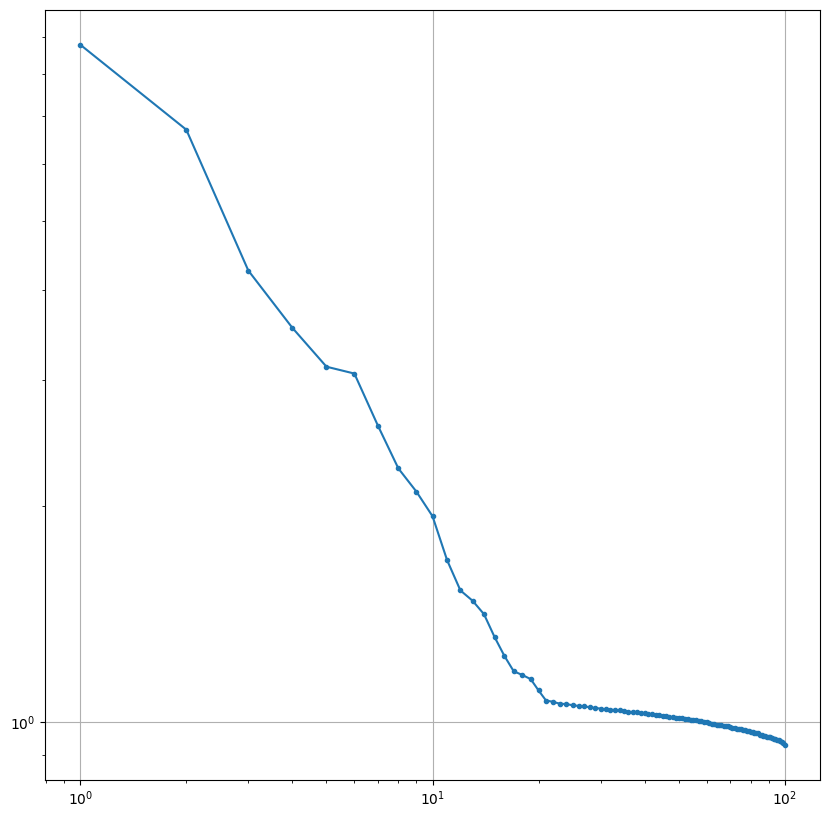

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")


- 通常のVAEでは, 中間層の出力のPC次元の分散はほぼ一様

In [41]:
from models import LitScaleFreeVAE

model_gamma = 0.5
model = LitScaleFreeVAE(n_vis=784, power_law_gamma=model_gamma, optimizer_name="adam")
data_module = FashionMNISTDataModule(batch_size=512)
trainer = pl.Trainer(
    max_epochs=10,
    devices=1,
    accelerator="gpu",
    logger=pl.loggers.TensorBoardLogger(save_dir=f"{tensorborad_dir}/scalefree"),
)
trainer.fit(model, data_module)


Training: 0it [00:00, ?it/s]

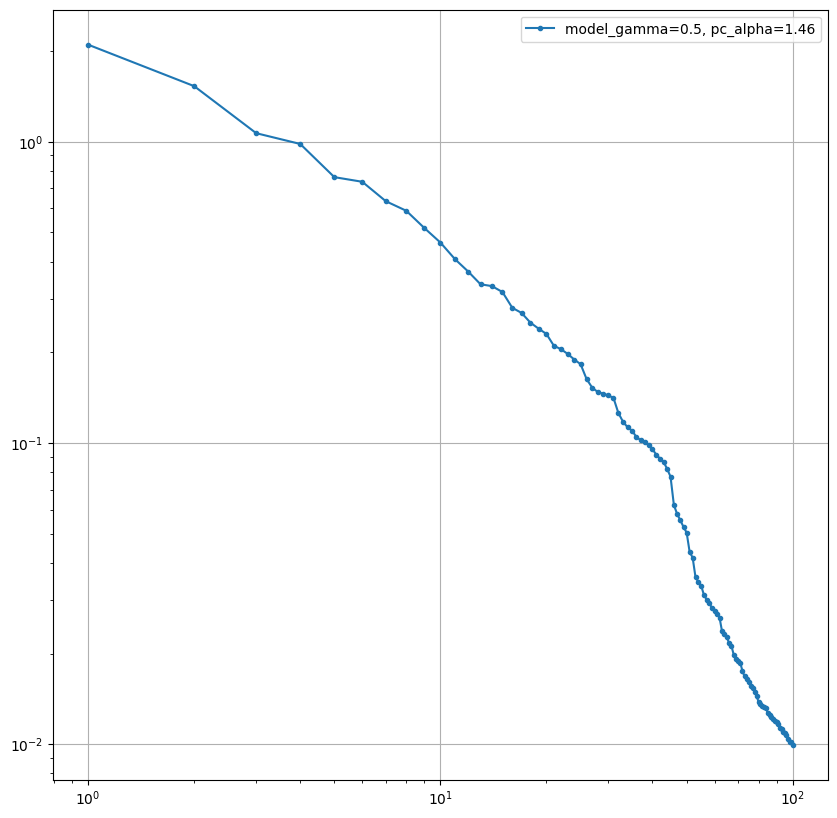

In [42]:
import numpy as np
from utils import sample_neuron_firings, pca_variance
import matplotlib.pyplot as plt

firings = model.sample_neuron_firings(data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)
m, c = np.linalg.lstsq(np.vstack([log_pc_dim, np.ones(len(log_pc_dim))]).T, log_var, rcond=None)[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-", label=f"model_gamma={model_gamma:.3}, pc_alpha={-m:.3}")
ax.legend()


- 中間層のサンプリングを, $i$次元のものを i/n 倍にするようにサプリング.

100%|██████████| 100/100 [09:39<00:00,  5.80s/it]


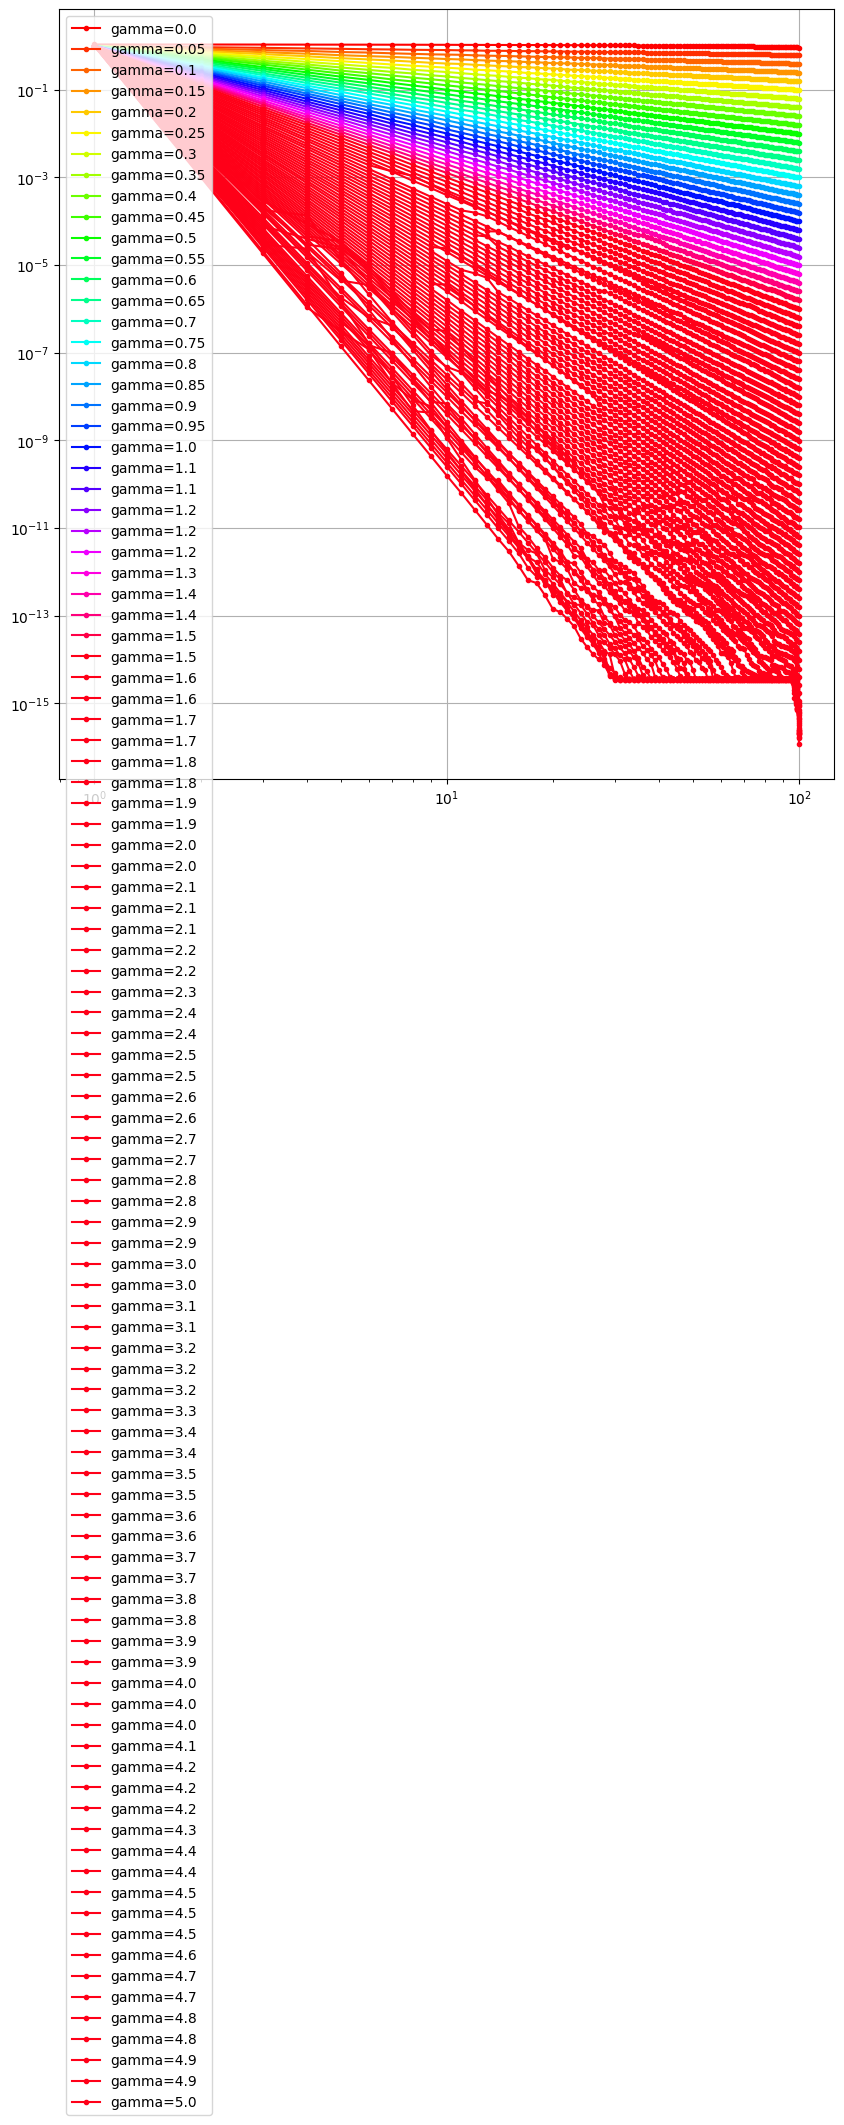

In [13]:
from datetime import datetime
import pytorch_lightning as pl

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule
from logzero import logger
import numpy as np
from utils import sample_neuron_firings, pca_variance
from models import LitScaleFreeVAE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import logging

from tqdm import tqdm

fig, ax = plt.subplots(figsize=(10, 10))

ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
epoch_loss_dicts = {}

for i, gamma in enumerate(tqdm([0.05 * i for i in range(100)])):
    model = LitScaleFreeVAE(n_vis=784, power_law_gamma=gamma)
    logger = pl.loggers.TensorBoardLogger(
        save_dir=f"{tensorborad_dir}/vary_gamma/{str(datetime.now())}_scalefree_gamma_{gamma:.2}"
    )
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
    data_module = FashionMNISTDataModule(batch_size=512)
    trainer = pl.Trainer(
        max_epochs=1, devices=1, accelerator="gpu", logger=logger, enable_progress_bar=False
    )
    trainer.fit(model, data_module)

    epoch_loss_dicts[f"{gamma:.2}"] = model.epoch_loss_dict

    firings = sample_neuron_firings(model, data_module.train_dataloader())
    pc_dim, pc_var = pca_variance(firings)
    ax.plot(pc_dim, pc_var, ".-", label=f"gamma={gamma:.2}", color=cm.hsv(i / 30.0))
    ax.legend()


- 通常VAEでは $\varepsilon_n \sim N(0, 1)$ のところを,  $\varepsilon_n \sim N(0, n^{-\gamma})$ とすることで, 潜在変数のPC次元分散分布を冪指数が$\gamma$ に比例したべき則になる.
    - 隠れ層のPC次元分布の冪指数は $2\gamma$ になる
    - これはおそらく loss の計算式 ` KL = 0.5 * torch.sum(1 + log_var - mean**2 - torch.exp(log_var))` に由来

In [5]:
%load_ext tensorboard
%tensorboard --logdir ../log/exp01

Reusing TensorBoard on port 6009 (pid 1274960), started 17 days, 23:37:40 ago. (Use '!kill 1274960' to kill it.)

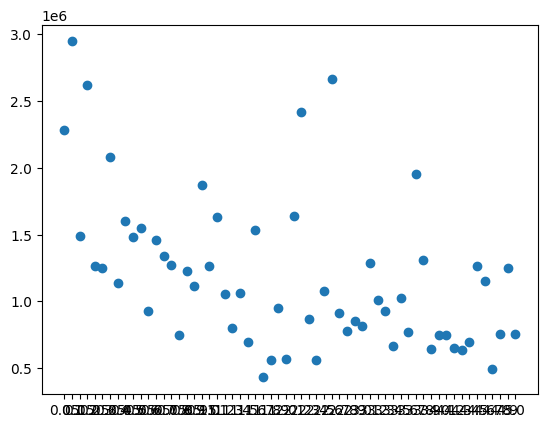

In [21]:
gammas = []
epoch1_losses = []
for gamma, value in epoch_loss_dicts.items():
    gammas.append(gamma)
    epoch1_losses.append(value["train_loss_epoch_ave"][0].cpu().numpy())

def reject_outliers(data):
    m = 2
    u = np.mean(data)
    s = np.std(data)
    filtered = [e for e in data if (u - 2 * s < e < u + 2 * s)]
    return filtered

data = reject_outliers(epoch1_losses)

plt.scatter(gammas[1:], data)

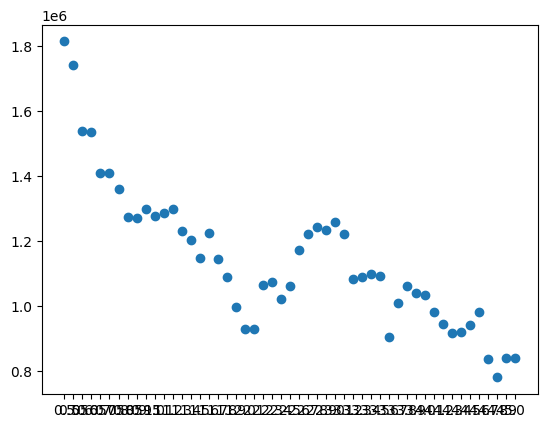

In [36]:
smoothing = 10
somoothed = np.convolve(data, np.ones(smoothing), mode="valid")/smoothing
plt.scatter(gammas[smoothing:], somoothed)

{'0.0': {'train_loss_epoch_ave': [tensor(2892475.7500, device='cuda:0'),
   tensor(1661854.8750, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '0.2': {'train_loss_epoch_ave': [tensor(1993117.6250, device='cuda:0'),
   tensor(1100723.2500, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '0.4': {'train_loss_epoch_ave': [tensor(1445027., device='cuda:0'),
   tensor(588995.5000, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '0.6': {'train_loss_epoch_ave': [tensor(1071672.1250, device='cuda:0'),
   tensor(578060.5000, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '0.8': {'train_loss_epoch_ave': [tensor(1243000.6250, device='cuda:0'),
   tensor(634238.4375, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '1.0': {'train_loss_epoch_ave': [tensor(1257922.1250, device='cuda:0'),
   tensor(577387.1250, device='cuda:0')],
  'valid_loss_epoch_ave': []},
 '1.2': {'train_loss_epoch_ave': [tensor(963259.6250, device='cuda:0'),
   tensor(472311.3438, device='cuda:0')],
  'valid_los

- 学習効率: 学習初期からの loss の大きさが, gamma によって大きく異る.
    - gamma: 1.0-1.6, 2.2-2.6 あたりが効率がよさそう?
    - データセット自体のべき則性が効いてしまっている可能性がある